# K-Means Clustering

Your assignment is to use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

It may be helpful to use PCA to reduce the dimensions of your data first in order to obtain --but then again, maybe not. I dunno, you're the data scientist, you tell me.🤪 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [20]:
df = df.drop('diagnosis', axis=1)
df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


# You take it from here!

See what you can come up with. You have all the know-how! 

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to do PCA on this data to see if that helps you find distinct linearly-separable clusters.
  - (In the real world, truly linearly-separable clusters are rare.)
- You might want to use an elbow chart to decide on the number of clusters to use.
- You might want to use a scree plot to decide how many principal components to include in your clustering.
- You might want to standardize your data before PCA (If you decide to use PCA). 

## Manage your time and don't spend it all on data exploration or something like that. You got this!

In [21]:
# drop column of NaN values & id column
df = df.drop(['Unnamed: 32', 'id'], axis=1)
df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Clustering Using PCA

In [23]:
# Standardize the data
df_norm = StandardScaler().fit_transform(df)

In [24]:
pca = PCA(len(df.columns))
pca.fit(df_norm)

print("\nExplained Variance:", pca.explained_variance_)


Explained Variance: [1.33049908e+01 5.70137460e+00 2.82291016e+00 1.98412752e+00
 1.65163324e+00 1.20948224e+00 6.76408882e-01 4.77456255e-01
 4.17628782e-01 3.51310875e-01 2.94433153e-01 2.61621161e-01
 2.41782421e-01 1.57286149e-01 9.43006956e-02 8.00034045e-02
 5.95036135e-02 5.27114222e-02 4.95647002e-02 3.12142606e-02
 3.00256631e-02 2.74877113e-02 2.43836914e-02 1.80867940e-02
 1.55085271e-02 8.19203712e-03 6.91261258e-03 1.59213600e-03
 7.50121413e-04 1.33279057e-04]


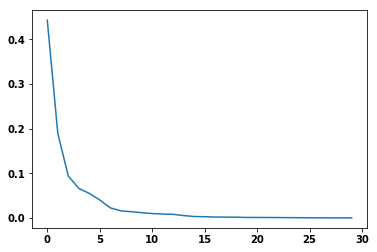

In [25]:
plt.plot(pca.explained_variance_ratio_);

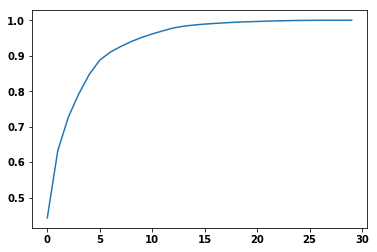

In [26]:
plt.plot(np.cumsum(pca.explained_variance_ratio_));

In [38]:
# keeping the first 2 components to avoid 3-d plotting
pca = PCA(n_components=2)
pca.fit(df_norm)
df_pca_trans = pd.DataFrame(pca.transform(df_norm))

print(df_pca_trans)

             0          1
0     9.192837   1.948583
1     2.387802  -3.768172
2     5.733896  -1.075174
3     7.122953  10.275589
4     3.935302  -1.948072
5     2.380247   3.949929
6     2.238883  -2.690031
7     2.143299   2.340244
8     3.174924   3.391813
9     6.351747   7.727174
10   -0.810414  -2.659275
11    2.651100   0.066568
12    8.185034   2.700976
13    0.342126  -0.968279
14    4.342379   4.861083
15    4.075656   2.977061
16    0.230055  -1.564758
17    4.418011   1.418670
18    4.948704  -4.114334
19   -1.237063  -0.188215
20   -1.578161   0.572808
21   -3.557336   1.662950
22    4.733211   3.304964
23    4.208524  -5.128367
24    4.949632  -1.543752
25    7.098563   2.018610
26    3.510263   2.171625
27    3.064054  -1.876552
28    4.007264   0.537242
29    1.715310  -1.523705
..         ...        ...
539  -1.142832   5.599458
540  -1.665475   2.389618
541   1.011712   1.092390
542  -1.300930  -1.821415
543  -2.373429  -1.681576
544  -1.665871  -0.213963
545  -1.9276

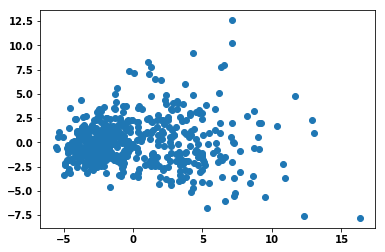

In [40]:
plt.scatter(df_pca_trans[0], df_pca_trans[1]);

In [41]:
sum_of_squared_dist = []
K = range(1, 20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca_trans)
    sum_of_squared_dist.append(km.inertia_)

print(sum_of_squared_dist)

[10795.615546121191, 5332.555574203128, 3864.545284007336, 3133.9580985467032, 2518.165012005828, 2193.5905535560714, 1874.4254576447647, 1629.2181426771251, 1467.1066365326121, 1353.876174692712, 1241.809267041142, 1127.248184074249, 1030.9227408197798, 951.6725000896026, 895.4043613996012, 814.5570874365571, 744.9096929805878, 709.7296171748869, 677.1680140476884]


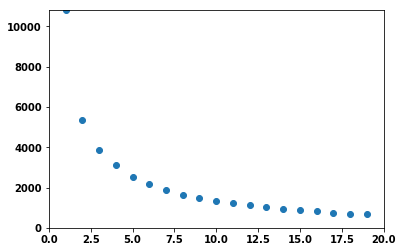

In [42]:
plt.scatter(x=range(1, 20), y=sum_of_squared_dist)
plt.ylim(0, max(sum_of_squared_dist))
plt.xlim(0, 20);

In [43]:
# Since there's a large drop off from 1-2, will use 2 clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_pca_trans)
labels = kmeans.labels_

print(labels)

[0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 1
 1 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1
 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1
 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 0
 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1
 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 0 1 0 1 1 1 1 0 

In [44]:
df_pca_trans['clusters'] = labels
df_pca_trans = df_pca_trans.rename(columns={0: 'x', 1: 'y'})
df_pca_trans.head()

,x,y,clusters
0,9.192837,1.948583,0
1,2.387802,-3.768172,0
2,5.733896,-1.075174,0
3,7.122953,10.275589,0
4,3.935302,-1.948072,0


In [49]:
# Plotting clusters function from lecture
def plot_clusters(df, column_header, centroids):
  colors = {0:'red', 1:'green', 2:'blue'}
  fig, ax = plt.subplots()
  ax.plot(x=centroids.iloc[0], y=centroids.iloc[0])
  ax.plot(x=centroids.iloc[1], y=centroids.iloc[1])
  plt.title('PCA with k-means clustering')

  #Un-comment to plot 3 clusters
  #ax.plot(centroids.iloc[2].x, centroids.iloc[2].y, "ok")

  grouped = df.groupby(column_header)
  for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
  plt.show()

In [50]:
def get_centroids(df,column):
  return df.groupby(column).mean() 

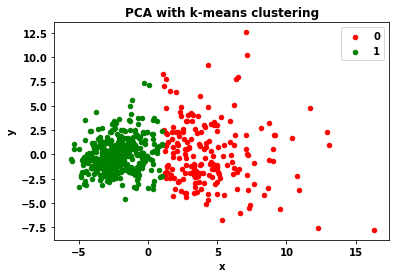

In [51]:
centroids = get_centroids(pca_df, 'clusters')
plot_clusters(df_pca_trans, 'clusters',centroids)

# Stretch Goal:

Once you are satisfied with your clustering, go back and add back in the labels from the original dataset to check how accurate your clustering was. Remember that this will not be a possibility in true unsupervised learning, but it might be a helpful for your learning to be able to check your work against the "ground truth". Try different approaches and see which one is the most successful and try understand why that might be the case. If you go back and try different methods don't ever include the actual "diagnosis" labels in your clustering or PCA.

**Side Note** Data Science is never DONE. You just reach a point where the cost isn't worth the benefit anymore. There's always more moderate to small improvements that we could make. Don't be a perfectionist, be a pragmatist.